# Lab 3 — dimensionality reduction

In [97]:
import json
import matplotlib.pyplot as plt
import numpy as np

from operator import itemgetter
from pyspark.sql import functions as F


%matplotlib inline
plt.style.use("ggplot")

In [26]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [27]:
sc

In [28]:
genome_tags_RDD = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(genome_tags_RDD.map(itemgetter("tagId", "tag")).collect())

In [29]:
len(tag2name)

1128

In [30]:
genome_scores_RDD = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
# genome_scores = data.collect() # RDD IS TOO BIG

### Exercise 3.1 

In [31]:
tag2name

{1: '007',
 2: '007 (series)',
 3: '18th century',
 4: '1920s',
 5: '1930s',
 6: '1950s',
 7: '1960s',
 8: '1970s',
 9: '1980s',
 10: '19th century',
 11: '3d',
 12: '70mm',
 13: '80s',
 14: '9/11',
 15: 'aardman',
 16: 'aardman studios',
 17: 'abortion',
 18: 'absurd',
 19: 'action',
 20: 'action packed',
 21: 'adaptation',
 22: 'adapted from:book',
 23: 'adapted from:comic',
 24: 'adapted from:game',
 25: 'addiction',
 26: 'adolescence',
 27: 'adoption',
 28: 'adultery',
 29: 'adventure',
 30: 'affectionate',
 31: 'afi 100',
 32: 'afi 100 (laughs)',
 33: 'afi 100 (movie quotes)',
 34: 'africa',
 35: 'afterlife',
 36: 'aging',
 37: 'aids',
 38: 'airplane',
 39: 'airport',
 40: 'alaska',
 41: 'alcatraz',
 42: 'alcoholism',
 43: 'alien',
 44: 'alien invasion',
 45: 'aliens',
 46: 'allegory',
 47: 'almodovar',
 48: 'alone in the world',
 49: 'alter ego',
 50: 'alternate endings',
 51: 'alternate history',
 52: 'alternate reality',
 53: 'alternate universe',
 54: 'amazing cinematography',

In [32]:
movies_rdd = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movies_rdd.map(lambda movie: movie['movieId']).max()

131262

In [33]:
movies = movies_rdd.collect()

In [34]:
len(movies)

27278

In [35]:
movies

[{'genres': ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
  'movieId': 1,
  'title': 'Toy Story (1995)'},
 {'genres': ['Adventure', 'Children', 'Fantasy'],
  'movieId': 2,
  'title': 'Jumanji (1995)'},
 {'genres': ['Comedy', 'Romance'],
  'movieId': 3,
  'title': 'Grumpier Old Men (1995)'},
 {'genres': ['Comedy', 'Drama', 'Romance'],
  'movieId': 4,
  'title': 'Waiting to Exhale (1995)'},
 {'genres': ['Comedy'],
  'movieId': 5,
  'title': 'Father of the Bride Part II (1995)'},
 {'genres': ['Action', 'Crime', 'Thriller'],
  'movieId': 6,
  'title': 'Heat (1995)'},
 {'genres': ['Comedy', 'Romance'], 'movieId': 7, 'title': 'Sabrina (1995)'},
 {'genres': ['Adventure', 'Children'],
  'movieId': 8,
  'title': 'Tom and Huck (1995)'},
 {'genres': ['Action'], 'movieId': 9, 'title': 'Sudden Death (1995)'},
 {'genres': ['Action', 'Adventure', 'Thriller'],
  'movieId': 10,
  'title': 'GoldenEye (1995)'},
 {'genres': ['Comedy', 'Drama', 'Romance'],
  'movieId': 11,
  'title': 'Americ

In [36]:
genome_scores_RDD.getNumPartitions()

6

In [115]:
smaller_genome_scores_RDD = genome_scores_RDD.filter(lambda x: x['movieId'] == 31 and x['tagId'] <= 4)

In [116]:
genome_scores = smaller_genome_scores_RDD.collect()

In [117]:
genome_scores

[{'movieId': 31, 'relevance': 0.04099999999999998, 'tagId': 1},
 {'movieId': 31, 'relevance': 0.05125000000000002, 'tagId': 2},
 {'movieId': 31, 'relevance': 0.020500000000000018, 'tagId': 3},
 {'movieId': 31, 'relevance': 0.032999999999999974, 'tagId': 4}]

In [105]:
genome_scores_DF = genome_scores_RDD.toDF(['movieId', 'relevance', 'tagId'])

/usr/hdp/2.5.3.0-37/spark/python/pyspark/sql/context.py:259: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [118]:
genome_groups = genome_scores_DF.groupBy('movieId').agg(F.collect_list('relevance'), F.collect_list('tagId'))

In [120]:
g = genome_groups.collect()

In [125]:
M_matrix = np.zeros( (len(tag2name), len(g)) ) 
M_matrix.shape

(1128, 10381)

In [135]:
for movie, row in enumerate(g):
    relevances = row[1]
    tags = row[2]
    
    for relevance, tag in zip(relevances, tags):
        M_matrix[tag - 1, movie] = relevance


In [136]:
M_matrix

array([[ 0.041  ,  0.04425,  0.027  , ...,  0.01825,  0.0385 ,  0.068  ],
       [ 0.05125,  0.04825,  0.02725, ...,  0.024  ,  0.03875,  0.08525],
       [ 0.0205 ,  0.01925,  0.01975, ...,  0.076  ,  0.024  ,  0.0215 ],
       ..., 
       [ 0.01225,  0.0115 ,  0.01125, ...,  0.01125,  0.0175 ,  0.009  ],
       [ 0.08025,  0.07825,  0.07225, ...,  0.076  ,  0.16825,  0.96475],
       [ 0.01675,  0.01425,  0.01825, ...,  0.01825,  0.0275 ,  0.93775]])

In [42]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry

M_Matrix_entity = genome_scores_RDD.map(lambda score: MatrixEntry(score["tagId"] - 1, score["movieId"] - 1, score["relevance"]))
M_Matrix_transposed_entity = genome_scores_RDD.map(lambda score: MatrixEntry(score["movieId"] - 1, score["tagId"] - 1, score["relevance"]))

In [43]:
M_Matrix_entity.first()

MatrixEntry(0, 0, 0.025000000000000022)

In [44]:
M_Matrix_coord = CoordinateMatrix(M_Matrix_entity)
M_Matrix_transposed_coord = CoordinateMatrix(M_Matrix_transposed_entity)

In [45]:
from pyspark.mllib.stat import Statistics

M_transposed_row = M_Matrix_transposed_coord.toRowMatrix()

# Compute column summary statistics.
summary = Statistics.colStats(M_transposed_row.rows)
print(summary.mean())  # a dense vector containing the mean value for each column
print(summary.variance())  # column-wise variance
print(summary.numNonzeros())  # number of nonzeros in each column

[ 0.04593457  0.04555156  0.06940533 ...,  0.04511629  0.11118832
  0.03019745]
[ 0.00490042  0.00374098  0.01184989 ...,  0.0188282   0.01105378
  0.00658031]
[ 10381.  10381.  10381. ...,  10381.  10381.  10381.]


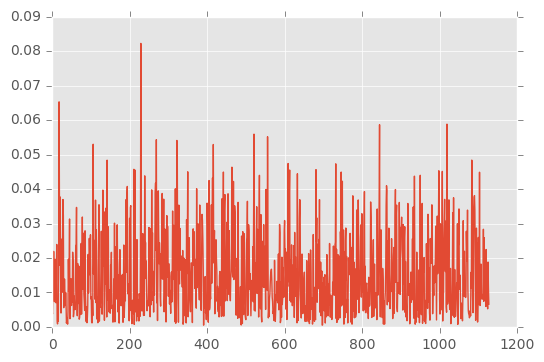

In [46]:
plt.plot(summary.variance())

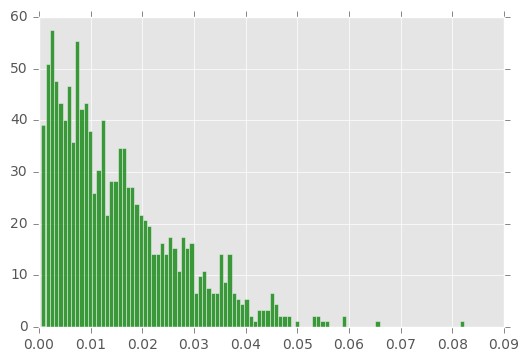

In [47]:
plt.hist(summary.variance(), bins=100, normed=1, facecolor='green', alpha=0.75)
plt.show()


#### Eigenvalues

In [140]:
# covariance matrix of M
M_cov = np.cov(M_matrix)
M_cov

array([[ 0.00490042,  0.00327346, -0.00030115, ...,  0.00016838,
        -0.00016172, -0.00014599],
       [ 0.00327346,  0.00374098, -0.00023234, ...,  0.00011866,
        -0.00015645, -0.00014514],
       [-0.00030115, -0.00023234,  0.01184989, ...,  0.00130349,
        -0.00112118, -0.00035662],
       ..., 
       [ 0.00016838,  0.00011866,  0.00130349, ...,  0.0188282 ,
        -0.00114338, -0.00032847],
       [-0.00016172, -0.00015645, -0.00112118, ..., -0.00114338,
         0.01105378,  0.00659333],
       [-0.00014599, -0.00014514, -0.00035662, ..., -0.00032847,
         0.00659333,  0.00658031]])

In [223]:
eigvalues, eigvectors = np.linalg.eigh(M_cov)

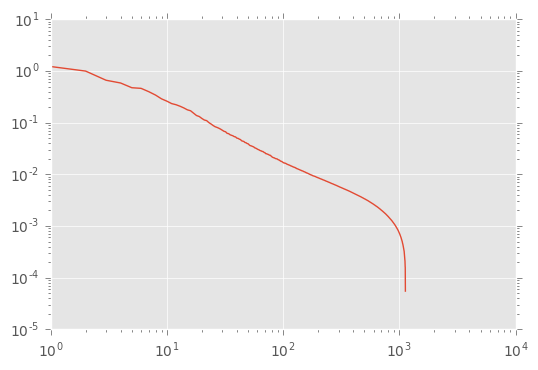

In [173]:
#TODO describe axes and title

eigvalues_plot = eigvalues.tolist()
eigvalues_plot.reverse()
plt.loglog(eigvalues_plot)
plt.show()

In [199]:
# For example, how many principal directions do you need to capture 2/3 of the variability in the data?
most_significant_principal_directions = [ n for n,i in enumerate(cumulative) if i<(1-(2./3) ) ][0]
most_significant_principal_directions

36

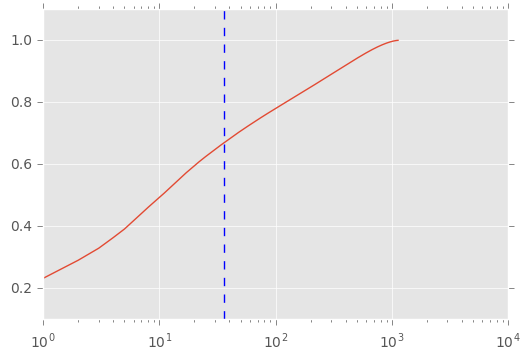

In [203]:
#TODO describe axes and title

cumulative = (np.cumsum(eigvalues_plot) / np.sum(eigvalues))
plt.semilogx(cumulative)
plt.axvline(most_significant_principal_directions, linestyle='dashed')
plt.show()

#### Exercise 3.2 Concept space

For the five first principal directions, find the 10 tags that have the highest and lowest
coordinates in that direction.

• What concepts would you use to describe these dimensions?

Create a Python dict which maps every tag (name) to its coordinates in the 5 first principal directions and save it to disk. This will be used later for the clustering exercise.

In [ ]:
#A * x = lambd * x

In [206]:
first_five_eigenvalues = eigvalues_plot[:5]
first_five_eigenvalues

[2.7533774797813484,
 1.2214710425886663,
 0.9960515193084871,
 0.6621755002074049,
 0.5857297851139425]

In [210]:
eigvectors

array([[ 0.00205699, -0.0053407 ,  0.0062789 , ...,  0.00124553,
        -0.01383799, -0.00572728],
       [-0.00078554, -0.00303118,  0.00347284, ...,  0.00206112,
        -0.01048045, -0.00478882],
       [ 0.00044356, -0.00104207,  0.00037798, ...,  0.02393293,
         0.00278201,  0.01246704],
       ..., 
       [ 0.00093566, -0.00050236,  0.00263286, ...,  0.03252862,
        -0.00551248,  0.01719115],
       [-0.00228662,  0.01518848,  0.00429738, ..., -0.0399581 ,
        -0.01417361, -0.01026643],
       [ 0.00059397, -0.01100711, -0.00067457, ..., -0.01634403,
        -0.00551606, -0.00137267]])

In [233]:
first_five_eigenvectors = eigvectors[:,-5:].T
first_five_eigenvectors

array([[ 0.00537026,  0.00320727,  0.02648181, ...,  0.03512377,
        -0.01902386, -0.00852925],
       [-0.00645959, -0.00525968,  0.01488517, ..., -0.01063545,
         0.00476552,  0.0037956 ],
       [ 0.00124553,  0.00206112,  0.02393293, ...,  0.03252862,
        -0.0399581 , -0.01634403],
       [-0.01383799, -0.01048045,  0.00278201, ..., -0.00551248,
        -0.01417361, -0.00551606],
       [-0.00572728, -0.00478882,  0.01246704, ...,  0.01719115,
        -0.01026643, -0.00137267]])

In [228]:
np.dot(M_cov, eigvectors[-1])

array([-0.00072957, -0.00066279,  0.00167351, ..., -0.00057301,
        0.00162098,  0.00070717])

In [227]:
eigvalues[-1]*eigvectors[-1]

array([ 0.00163542, -0.03030672, -0.00185735, ..., -0.04500129,
       -0.01518779, -0.00377948])

In [229]:
(eigvalues[-1]*first_five_eigenvectors[-1]) / (np.dot(M_cov, first_five_eigenvectors[-1]))

array([ -2.2416183 ,  45.72594765,  -1.10985082, ...,  78.53457472,
        -9.36948534,  -5.3445201 ])

In [230]:
np.dot(M_cov, eigvectors[:, 0]) - eigvalues[0] * eigvectors[:, 0] # verify 1st e-val/vec pair
# array([2.77555756e-17 + 0.j, 0. + 1.38777878e-16j])
# np.dot(M_cov, v[:, 1]) - w[1] * v[:, 1] # verify 2nd e-val/vec pair
# array([ 0.+0.j,  0.+0.j])

array([ -2.94145426e-19,   2.50808441e-18,   3.34998222e-19, ...,
         1.29225464e-19,   5.59571141e-20,   5.10747632e-19])